#Recommendation system


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


#loading datasets

In [ ]:
columns=['userId', 'bookId', 'ratings','timestamp']
books_df=pd.read_csv('ratings.csv',names=columns)
books_df.head()

,userId,bookId,ratings,timestamp
0,121,788,2,894432894
1,214,535,1,851414595
2,32,321,2,816630481
3,15,995,2,803104598
4,109,697,2,863619619


drop time stamp column

In [ ]:
books_df.drop('timestamp',axis=1,inplace=True)

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   userId   1013 non-null   int64
 1   bookId   1013 non-null   int64
 2   ratings  1013 non-null   int64
dtypes: int64(3)
memory usage: 23.9 KB


to check number of rows and columns

In [ ]:
rows,columns=books_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  1013
Number of columns:  3


In [ ]:
books_df.dtypes

userId     int64
bookId     int64
ratings    int64
dtype: object

summary about ratings column

In [ ]:
books_df['ratings'].describe().transpose()

count    1013.000000
mean        3.077986
std         1.435999
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: ratings, dtype: float64

To print the max and min values to know bound of rating

In [ ]:
print('Minimum rating is: %d' %(books_df.ratings.min()))
print('Maximum rating is: %d' %(books_df.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


check missing values

In [ ]:
print('Number of missing values across columns: \n',books_df.isnull().sum())

Number of missing values across columns: 
 userId     0
bookId     0
ratings    0
dtype: int64


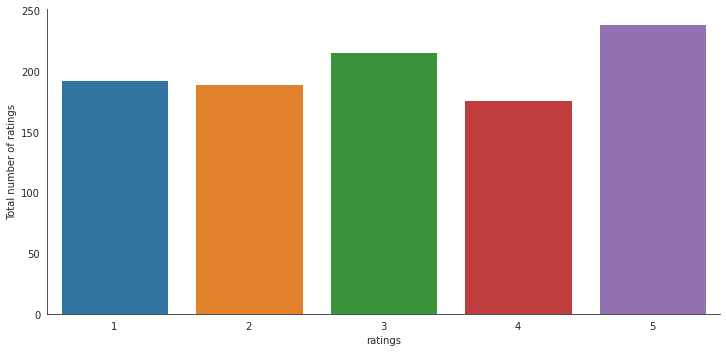

In [ ]:

# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=books_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [ ]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', books_df['userId'].nunique(dropna=False))

Number of unique users in Raw data =  294


In [ ]:
#Check the top 10 users based on ratings
most_rated=books_df.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
103    12
173     9
140     8
66      8
73      8
78      8
189     8
53      8
160     7
253     7
dtype: int64


this code shows the number of unique users,unique products and users who have rated above 5 books

In [ ]:
counts=books_df.userId.value_counts()
books_df1_final=books_df[books_df.userId.isin(counts[counts>=5].index)]
print('Number of users who have rated 5 or more items =', len(books_df1_final))
print('Number of unique users in the final data = ', books_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', books_df1_final['userId'].nunique())

Number of users who have rated 5 or more items = 420
Number of unique users in the final data =  71
Number of unique products in the final data =  71


In [ ]:

#constructing the pivot table
final_ratings_matrix = books_df1_final.pivot(index ='bookId', columns ='userId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

userId,3,18,19,20,25,32,33,42,48,53,66,69,73,78,85,86,90,101,103,106,108,111,115,134,136,138,140,143,144,147,151,152,156,160,165,173,180,181,187,188,189,190,201,204,210,212,215,219,223,233,235,239,240,241,245,250,253,255,260,266,267,274,276,281,295,296,298,304,305,306,307
bookId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (420, 71)


Calucating the density of the rating marix

In [ ]:
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  420
possible_num_of_ratings =  29820
density: 1.41%


In [ ]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(books_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,bookId,ratings
271,305,82,3
922,239,785,4
170,305,391,3
707,204,932,1
1000,204,981,5


In [ ]:
#printing the shape matrix of the table
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (294, 3)
Shape of testing data:  (126, 3)


In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('userId').agg({'bookId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'bookId': 'score'},inplace=True)
train_data_grouped.head(40)

,userId,score
0,3,5
1,18,3
2,19,6
3,20,4
4,25,3
5,32,6
6,33,3
7,42,3
8,48,5
9,53,7


In [ ]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'userId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,userId,score,rank
9,53,7,1.0
12,73,7,2.0
18,103,7,3.0
40,189,7,4.0
2,19,6,5.0


In [ ]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [ ]:
find_recom = [10,100]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

    rank  userId  score
9    1.0      10      7
12   2.0      10      7
18   3.0      10      7
40   4.0      10      7
2    5.0      10      6


The list of recommendations for the userId: 100

    rank  userId  score
9    1.0     100      7
12   2.0     100      7
18   3.0     100      7
40   4.0     100      7
2    5.0     100      6




#Conclusion
Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. 

#chapter 2
#Collaborative filering recommendation model

In [ ]:
books_df_CF = pd.concat([train_data, test_data]).reset_index()
books_df_CF.head()

,index,userId,bookId,ratings
0,271,305,82,3
1,922,239,785,4
2,170,305,391,3
3,707,204,932,1
4,1000,204,981,5


product(books) based recommendation

In [ ]:
# Matrix with row per 'book' and column per 'user' 
pivot_df = books_df_CF.pivot(index = 'bookId', columns ='userId', values = 'ratings').fillna(0)
pivot_df.head()

userId,3,18,19,20,25,32,33,42,48,53,66,69,73,78,85,86,90,101,103,106,108,111,115,134,136,138,140,143,144,147,151,152,156,160,165,173,180,181,187,188,189,190,201,204,210,212,215,219,223,233,235,239,240,241,245,250,253,255,260,266,267,274,276,281,295,296,298,304,305,306,307
bookId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (420, 71)


In [ ]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

userId,3,18,19,20,25,32,33,42,48,53,66,69,73,78,85,86,90,101,103,106,108,111,115,134,136,138,140,143,144,147,151,152,156,160,165,173,180,181,187,188,189,190,201,204,210,212,215,219,223,233,235,239,240,241,245,250,253,255,260,266,267,274,276,281,295,296,298,304,305,306,307,user_index
bookId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
#As this is a sparse matrix we will use SVD.
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

userId,3,18,19,20,25,32,33,42,48,53,66,69,73,78,85,86,90,101,103,106,108,111,115,134,136,138,140,143,144,147,151,152,156,160,165,173,180,181,187,188,189,190,201,204,210,212,215,219,223,233,235,239,240,241,245,250,253,255,260,266,267,274,276,281,295,296,298,304,305,306,307
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [ ]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-1.69501985e-18 -1.69123902e-17  2.95273177e-19 ...  8.12838076e-19
  -5.24387168e-19 -5.01092710e-19]
 [ 1.67226131e-18 -7.49824579e-19  3.35365633e-18 ...  4.50672360e-18
  -8.36449832e-19 -2.96062359e-19]
 [ 9.71585157e-16 -1.04576684e-15 -3.82832695e-16 ... -6.62098291e-17
   3.00758151e-17 -2.38923141e-17]
 ...
 [-1.53057100e-18 -4.03274154e-17 -4.09195573e-17 ...  1.73755954e-18
   3.29207753e-18 -3.96634327e-18]
 [-1.79313020e-17 -1.01087724e-14 -5.02518908e-01 ... -5.23817120e-17
  -3.37063687e-17 -2.81706260e-17]
 [ 1.35351669e-17 -1.70105333e-17 -1.04588213e-18 ... -1.68417506e-18
   4.49619001e-18  4.58779102e-18]]


In [ ]:
print('Sigma: \n',sigma)

Sigma: 
 [ 9.64365076  9.79795897  9.94987437 10.19803903 10.19803903 10.58300524
 10.86278049 11.04536102 11.44552314 12.28820573]


In [ ]:
#As sigma is not a diagonal matrix we have to convert it into diagonal matrix.
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 9.64365076  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          9.79795897  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          9.94987437  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         10.19803903  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         10.19803903  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         10.58300524
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  10.86278049  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         11.04536102  0.          0.        ]
 [ 0.          0.          0.        

In [ ]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 8.06335205e-18 -1.00000000e+00 -1.06630001e-17  1.41948050e-16
  -4.35194236e-18 -6.34450977e-18 -2.91859416e-18  1.06489437e-17
   6.53768013e-17  3.53838209e-17  1.20941930e-16  1.63374530e-16
  -1.54529787e-18  3.75711233e-17  4.09976253e-18 -9.94075472e-17
   1.42523034e-17 -2.37787055e-16  0.00000000e+00 -4.38398194e-16
  -5.75355009e-18 -5.15427522e-17 -2.38077560e-18  1.11329736e-16
  -1.06239109e-16  4.54938206e-17 -3.45846429e-17 -9.21048057e-18
   2.03762277e-17 -3.16752797e-17 -4.05309053e-17 -8.82364384e-17
  -2.39638327e-17 -1.31429898e-15  8.68949267e-17  1.05490524e-15
  -1.55139345e-19  1.53109003e-17  1.40136601e-16 -5.53395847e-18
   4.80860604e-18 -8.35755481e-17  4.12697788e-18  2.41737427e-17
  -3.94021957e-17  4.15071889e-17  4.58234547e-16 -6.42886310e-17
   1.83531504e-16 -1.99664669e-17 -1.27759979e-16 -4.92009740e-18
  -1.00932901e-18  2.32991176e-17  2.34240698e-15 -5.90685958e-18
  -5.61593815e-18  7.91330607e-17  3.11352016e-16 -

In [ ]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

userId,3,18,19,20,25,32,33,42,48,53,66,69,73,78,85,86,90,101,103,106,108,111,115,134,136,138,140,143,144,147,151,152,156,160,165,173,180,181,187,188,189,190,201,204,210,212,215,219,223,233,235,239,240,241,245,250,253,255,260,266,267,274,276,281,295,296,298,304,305,306,307
0,2.888255e-33,1.634618e-17,-6.330136e-32,2.019337e-32,9.800859e-33,-7.743369e-33,7.283113e-32,5.506558e-34,2.456811e-33,-8.619273e-32,3.102222e-32,-4.314123e-32,-8.978090e-18,-3.115726e-32,7.064703e-34,-1.057675e-32,-4.123617e-32,-3.395990e-32,-6.157530e-18,3.858268e-32,-3.203935e-32,-2.856216e-33,5.877273e-33,-1.415282e-17,3.154476e-32,2.086585e-32,-2.937931e-18,-1.953548e-32,9.523071e-18,8.776247e-32,-2.290108e-32,4.238975e-32,2.171811e-33,3.225091e-31,3.972423e-32,1.832747e-31,-4.394732e-35,1.298479e-33,-1.991390e-32,1.197129e-17,6.001885e-18,-7.590544e-33,-7.642794e-33,2.817632e-32,-9.136583e-33,-2.994925e-33,-3.550614e-32,-1.071894e-32,2.049842e-34,-1.065664e-32,-6.423018e-18,2.247568e-32,-6.506229e-33,-1.657069e-16,3.514916e-31,2.294567e-32,-3.661379e-17,1.052603e-32,-2.768847e-33,1.485264e-32,2.107295e-32,-1.676085e-33,4.899773e-33,1.112542e-32,1.093179e-32,2.017464e-33,-1.251195e-32,-2.737906e-32,-5.619013e-33,1.264527e-32,-2.509715e-32
1,9.958418e-33,-1.612670e-17,-7.619137e-33,1.619427e-34,-1.314177e-33,-7.105454e-33,-2.315576e-33,-9.844160e-34,8.061626e-34,6.936355e-32,-2.985074e-32,9.582467e-33,-4.977839e-17,-2.069065e-32,-3.468154e-33,8.830929e-34,3.743160e-35,-4.949258e-33,-3.638075e-18,-1.038679e-32,-1.543057e-32,-5.025044e-33,-5.246221e-33,-5.227780e-17,-9.404179e-33,6.028368e-33,-3.336846e-17,-1.727467e-32,6.273715e-17,1.198611e-32,-1.575792e-32,5.496243e-34,-2.226801e-32,9.204320e-32,-1.039570e-32,1.133774e-31,-8.060174e-35,2.020223e-33,2.773426e-33,2.774205e-17,9.573606e-18,-8.772079e-33,1.045398e-32,1.195284e-32,7.549533e-35,2.463323e-32,1.011662e-32,2.083816e-33,-8.956043e-33,-4.960757e-33,-7.279990e-17,-1.140545e-33,-3.232440e-34,-7.346750e-18,2.552060e-32,-8.607152e-33,-5.628670e-17,-2.789768e-33,-7.557285e-33,2.888255e-33,-3.593378e-33,-1.603729e-32,-9.396741e-33,3.384121e-33,3.079930e-33,2.689488e-33,-1.265641e-33,-4.942524e-32,2.114311e-33,-2.975718e-33,6.450510e-33
2,5.104120e-32,-9.369628e-15,-4.020149e-30,2.585792e-30,7.203599e-31,-1.306049e-31,5.568377e-30,3.998655e-31,-3.722410e-31,7.844658e-30,6.659189e-30,-1.067908e-30,7.313115e-16,-2.785563e-31,6.307688e-31,-1.669412e-30,-2.982245e-30,-7.140815e-30,-2.935937e-16,-2.080866e-30,-1.173105e-30,-8.406551e-31,5.077126e-31,5.980696e-15,8.163301e-31,1.376716e-30,3.809137e-15,-6.283797e-31,8.039322e-16,4.276559e-30,-9.206320e-31,3.037065e-30,6.649924e-31,-4.199466e-30,2.737570e-30,6.574635e-30,-1.587510e-33,2.837144e-31,-1.386256e-30,8.223433e-17,-3.442334e-16,-1.519334e-30,-9.094281e-31,1.494341e-30,-1.314116e-30,-6.751548e-31,2.580396e-30,-1.696258e-30,1.302013e-30,-4.703124e-31,-5.882803e-15,1.731710e-30,-6.078074e-31,-1.024638e-14,7.103459e-29,5.807161e-32,2.254316e-15,1.919985e-30,-1.080539e-30,7.029832e-31,3.349526e-30,7.773784e-31,4.995033e-31,1.586822e-30,-2.050763e-31,3.778145e-31,-1.223079e-30,-3.193695e-29,-1.091138e-30,1.859141e-31,-4.592843e-31
3,4.160139e-33,-4.204098e-16,2.101346e-31,1.381690e-31,-5.746336e-32,-1.341940e-32,-4.496321e-31,-5.723764e-32,1.682321e-31,-3.523328e-31,-9.710954e-32,8.952901e-32,3.463204e-16,-8.295241e-32,-1.201007e-31,-9.027006e-32,2.591669e-31,1.039690e-31,-2.675124e-17,-4.587127e-31,2.905352e-32,-1.085598e-32,-3.306274e-32,-4.968553e-16,-1.487409e-31,1.222564e-32,-9.485704e-16,-1.331510e-32,1.099886e-16,-7.657496e-32,-3.113151e-32,-3.670244e-31,-6.933545e-32,2.766013e-30,2.226253e-32,3.837821e-30,-1.734616e-34,-1.046390e-32,6.709020e-31,2.104843e-16,-1.527015e-16,2.124343e-32,8.227356e-32,6.927521e-33,1.308415e-31,8.888382e-32,4.344611e-31,-6.728637e-32,-1.964591e-31,-1.937666e-32,1.739557e-16,-1.583049e-31,1.216536e-32,2.289596e-16,-1.039692e-30,3.044556e-32,6.373814e-16,8.247897e-32,1.201758e-31,-2.987085e-32,1.442466e-31,-7.678954e-32,-2

Collaborative filtering algorithm 
to recommend books for the users

In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
253                         0.0      6.373814e-16
73                          0.0      3.463204e-16
241                         0.0      2.289596e-16
188                         0.0      2.104843e-16
235                         0.0      1.739557e-16


In [ ]:
userID = 59
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 59):

                   user_ratings  user_predictions
Recommended Items                                
140                         0.0      2.746916e-16
18                          0.0      8.823644e-17
144                         0.0      3.651063e-17
188                         0.0      3.050763e-17
245                         0.0      7.592663e-31


In [ ]:
userID = 301
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 301):

                   user_ratings  user_predictions
Recommended Items                                
73                          0.0      2.541325e-15
188                         0.0      7.854766e-16
147                         0.0      6.595192e-16
86                          0.0      4.214482e-16
134                         0.0      3.884199e-16


#Conclusion
Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

#Evaluation of Collabrative recommendation model

In [ ]:
#Evaluation of Collabrative recommendation model
# Actual ratings given by the users
final_ratings_matrix.head()


userId,3,18,19,20,25,32,33,42,48,53,66,69,73,78,85,86,90,101,103,106,108,111,115,134,136,138,140,143,144,147,151,152,156,160,165,173,180,181,187,188,189,190,201,204,210,212,215,219,223,233,235,239,240,241,245,250,253,255,260,266,267,274,276,281,295,296,298,304,305,306,307
bookId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Average ACTUAL rating values given by the users for books
final_ratings_matrix.mean().head()

userId
3     0.038095
18    0.050000
19    0.047619
20    0.026190
25    0.042857
dtype: float64

In [ ]:
# Predicted ratings 
preds_df.head()

userId,3,18,19,20,25,32,33,42,48,53,66,69,73,78,85,86,90,101,103,106,108,111,115,134,136,138,140,143,144,147,151,152,156,160,165,173,180,181,187,188,189,190,201,204,210,212,215,219,223,233,235,239,240,241,245,250,253,255,260,266,267,274,276,281,295,296,298,304,305,306,307
0,2.888255e-33,1.634618e-17,-6.330136e-32,2.019337e-32,9.800859e-33,-7.743369e-33,7.283113e-32,5.506558e-34,2.456811e-33,-8.619273e-32,3.102222e-32,-4.314123e-32,-8.978090e-18,-3.115726e-32,7.064703e-34,-1.057675e-32,-4.123617e-32,-3.395990e-32,-6.157530e-18,3.858268e-32,-3.203935e-32,-2.856216e-33,5.877273e-33,-1.415282e-17,3.154476e-32,2.086585e-32,-2.937931e-18,-1.953548e-32,9.523071e-18,8.776247e-32,-2.290108e-32,4.238975e-32,2.171811e-33,3.225091e-31,3.972423e-32,1.832747e-31,-4.394732e-35,1.298479e-33,-1.991390e-32,1.197129e-17,6.001885e-18,-7.590544e-33,-7.642794e-33,2.817632e-32,-9.136583e-33,-2.994925e-33,-3.550614e-32,-1.071894e-32,2.049842e-34,-1.065664e-32,-6.423018e-18,2.247568e-32,-6.506229e-33,-1.657069e-16,3.514916e-31,2.294567e-32,-3.661379e-17,1.052603e-32,-2.768847e-33,1.485264e-32,2.107295e-32,-1.676085e-33,4.899773e-33,1.112542e-32,1.093179e-32,2.017464e-33,-1.251195e-32,-2.737906e-32,-5.619013e-33,1.264527e-32,-2.509715e-32
1,9.958418e-33,-1.612670e-17,-7.619137e-33,1.619427e-34,-1.314177e-33,-7.105454e-33,-2.315576e-33,-9.844160e-34,8.061626e-34,6.936355e-32,-2.985074e-32,9.582467e-33,-4.977839e-17,-2.069065e-32,-3.468154e-33,8.830929e-34,3.743160e-35,-4.949258e-33,-3.638075e-18,-1.038679e-32,-1.543057e-32,-5.025044e-33,-5.246221e-33,-5.227780e-17,-9.404179e-33,6.028368e-33,-3.336846e-17,-1.727467e-32,6.273715e-17,1.198611e-32,-1.575792e-32,5.496243e-34,-2.226801e-32,9.204320e-32,-1.039570e-32,1.133774e-31,-8.060174e-35,2.020223e-33,2.773426e-33,2.774205e-17,9.573606e-18,-8.772079e-33,1.045398e-32,1.195284e-32,7.549533e-35,2.463323e-32,1.011662e-32,2.083816e-33,-8.956043e-33,-4.960757e-33,-7.279990e-17,-1.140545e-33,-3.232440e-34,-7.346750e-18,2.552060e-32,-8.607152e-33,-5.628670e-17,-2.789768e-33,-7.557285e-33,2.888255e-33,-3.593378e-33,-1.603729e-32,-9.396741e-33,3.384121e-33,3.079930e-33,2.689488e-33,-1.265641e-33,-4.942524e-32,2.114311e-33,-2.975718e-33,6.450510e-33
2,5.104120e-32,-9.369628e-15,-4.020149e-30,2.585792e-30,7.203599e-31,-1.306049e-31,5.568377e-30,3.998655e-31,-3.722410e-31,7.844658e-30,6.659189e-30,-1.067908e-30,7.313115e-16,-2.785563e-31,6.307688e-31,-1.669412e-30,-2.982245e-30,-7.140815e-30,-2.935937e-16,-2.080866e-30,-1.173105e-30,-8.406551e-31,5.077126e-31,5.980696e-15,8.163301e-31,1.376716e-30,3.809137e-15,-6.283797e-31,8.039322e-16,4.276559e-30,-9.206320e-31,3.037065e-30,6.649924e-31,-4.199466e-30,2.737570e-30,6.574635e-30,-1.587510e-33,2.837144e-31,-1.386256e-30,8.223433e-17,-3.442334e-16,-1.519334e-30,-9.094281e-31,1.494341e-30,-1.314116e-30,-6.751548e-31,2.580396e-30,-1.696258e-30,1.302013e-30,-4.703124e-31,-5.882803e-15,1.731710e-30,-6.078074e-31,-1.024638e-14,7.103459e-29,5.807161e-32,2.254316e-15,1.919985e-30,-1.080539e-30,7.029832e-31,3.349526e-30,7.773784e-31,4.995033e-31,1.586822e-30,-2.050763e-31,3.778145e-31,-1.223079e-30,-3.193695e-29,-1.091138e-30,1.859141e-31,-4.592843e-31
3,4.160139e-33,-4.204098e-16,2.101346e-31,1.381690e-31,-5.746336e-32,-1.341940e-32,-4.496321e-31,-5.723764e-32,1.682321e-31,-3.523328e-31,-9.710954e-32,8.952901e-32,3.463204e-16,-8.295241e-32,-1.201007e-31,-9.027006e-32,2.591669e-31,1.039690e-31,-2.675124e-17,-4.587127e-31,2.905352e-32,-1.085598e-32,-3.306274e-32,-4.968553e-16,-1.487409e-31,1.222564e-32,-9.485704e-16,-1.331510e-32,1.099886e-16,-7.657496e-32,-3.113151e-32,-3.670244e-31,-6.933545e-32,2.766013e-30,2.226253e-32,3.837821e-30,-1.734616e-34,-1.046390e-32,6.709020e-31,2.104843e-16,-1.527015e-16,2.124343e-32,8.227356e-32,6.927521e-33,1.308415e-31,8.888382e-32,4.344611e-31,-6.728637e-32,-1.964591e-31,-1.937666e-32,1.739557e-16,-1.583049e-31,1.216536e-32,2.289596e-16,-1.039692e-30,3.044556e-32,6.373814e-16,8.247897e-32,1.201758e-31,-2.987085e-32,1.442466e-31,-7.678954e-32,-2

In [ ]:
# Average PREDICTED rating for each item
preds_df.mean().head()

userId
3    -5.829583e-18
18    5.000000e-02
19    1.531635e-17
20   -3.426746e-18
25   -4.325143e-19
dtype: float64

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(71, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
userId,,,
3,0.038095,-5.829583e-18,0
18,0.050000,5.000000e-02,1
19,0.047619,1.531635e-17,2
20,0.026190,-3.426746e-18,3
25,0.042857,-4.325143e-19,4


In [ ]:
#root mean square error
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.03899 



Getting top - K ( K = 5) recommendations

In [ ]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 209
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 209):

                   user_ratings  user_predictions
Recommended Items                                
241                         0.0      4.442697e-16
144                         0.0      7.851338e-17
140                         0.0      3.196239e-17
189                         0.0      3.069559e-17
53                          0.0      3.372235e-31
